In [187]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom
from itertools import permutations
import math
from statistics import mean
import random
from scipy.stats import gamma
import matplotlib.pyplot as  plt
import copy
import scipy.stats


In [188]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Import Cases and Vaccination datasets (X dataset)

In [189]:
cases_df_id_de_daily_de_final=pd.read_csv("/content/gdrive/MyDrive/delaware_cases.csv")
cases_df_id_de_daily_id_final=pd.read_csv("/content/gdrive/MyDrive/idaho_cases.csv")
vaccine_daily_de=pd.read_csv("/content/gdrive/MyDrive/delaware_vaccines.csv")
vaccine_daily_id=pd.read_csv("/content/gdrive/MyDrive/idaho_vaccines.csv")

In [190]:
### Question 2b

#Question 2b

In [191]:
cases_df_id_de_daily_de_final['submission_date'] = pd.to_datetime(cases_df_id_de_daily_de_final['submission_date'])
cases_df_id_de_daily_id_final['submission_date'] = pd.to_datetime(cases_df_id_de_daily_id_final['submission_date'])

#Filtering rows to get data from 1st October to 31st December

In [192]:
three_month_condition_de = (cases_df_id_de_daily_de_final['submission_date'] >= '2021-10-01') & (cases_df_id_de_daily_de_final['submission_date'] <= '2021-12-31')
three_month_condition_id = (cases_df_id_de_daily_id_final['submission_date'] >= '2021-10-01') & (cases_df_id_de_daily_id_final['submission_date'] <= '2021-12-31')

In [193]:
three_month_de_data = cases_df_id_de_daily_de_final.loc[three_month_condition_de]
three_month_id_data = cases_df_id_de_daily_id_final.loc[three_month_condition_id]

In [194]:
three_month_de_data

,tot_cases,tot_death,submission_date,state,new_case,pnew_case,new_death,pnew_death,created_at,consent_cases,consent_deaths,prob_cases,conf_cases,conf_death,prob_death,tot_cases_old,tot_death_old
510,630,0,2021-10-01,DE,630,79.0,0,0.0,10/03/2021 12:00:00 AM,Agree,Agree,10322.0,122236.0,1788.0,166.0,132558,1954
511,403,0,2021-10-03,DE,403,61.0,0,0.0,10/05/2021 12:00:00 AM,Agree,Agree,10421.0,123174.0,1805.0,167.0,133595,1972
512,381,0,2021-10-04,DE,381,53.0,0,0.0,10/06/2021 12:00:00 AM,Agree,Agree,10474.0,123502.0,1805.0,167.0,133976,1972
513,270,3,2021-10-05,DE,270,23.0,3,0.0,10/07/2021 12:00:00 AM,Agree,Agree,10497.0,123749.0,1808.0,167.0,134246,1975
514,444,2,2021-10-06,DE,444,45.0,2,0.0,10/08/2021 12:00:00 AM,Agree,Agree,10542.0,124148.0,1810.0,167.0,134690,1977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,683,0,2021-12-20,DE,683,61.0,0,0.0,12/22/2021 12:00:00 AM,Agree,Agree,13690.0,151575.0,2053.0,189.0,165265,2242
572,541,7,2021-12-21,DE,541,35.0,7,0.0,12/23/2021 12:00:00 AM,Agree,Agree,13725.0,152081.0,2060.0,189.0,165806,2249
573,665,0,2021-12-22,DE,665,38.0,0,0.0,12/24/2021 12:00:00 AM,Agree,Agree,13763.0,152708.0,2060.0,189.0,166471,2249
574,451,0,2021-12-27,DE,451,37.0,0,0.0,12/29/2021 12:00:00 AM,Agree,Agree,14353.0,157901.0,2080.0,191.0,172254,2271


In [195]:
def MME(type, X):
  if type == 'poisson':
    return np.mean(X)
  elif type == 'binomial':
    m = np.mean(X)
    v = np.var(X)
    return 1 - (v/m), m / (1 - (v/m))
  elif type == 'geometric':
    return 1 / np.mean(X)


In [196]:
def generate_CDF(type, X, params):
  if type == 'poisson':
    return poisson.cdf(X, params[0])
  elif type == 'binomial':
    return binom.cdf(X, params[0], params[1])
  elif type == 'geometric':
    return geom.cdf(X, params[0])




In [197]:
def generate_eCDF(X):
  n = len(X)
  Srt = sorted(X)
  delta = .1
  X = [min(Srt)-delta]
  Y = [0]
  for i in range(0, n):
      X = X + [Srt[i], Srt[i]]
      Y = Y + [Y[len(Y)-1], Y[len(Y)-1]+(1/n)]
  X = X + [max(Srt)+delta]
  # print(X)
  Y = Y + [1]
  return X, Y

In [198]:
def ks_test_1_sample(X1,Y1, cdf_function, parameter):
    tot_max = -1
    ks_table = np.zeros((len(X1),4))
    for i in range(len(ks_table)-1):
        ks_table[i,0] = Y1[i]
        ks_table[i,1] = Y1[i+1]
        F_x = generate_CDF(cdf_function, X1[i], parameter)
        ks_table[i,2] = abs(ks_table[i,0] - F_x)
        ks_table[i,3] = abs(ks_table[i,1] - F_x)
        cmax = max(ks_table[i,2], ks_table[i,3])
        if cmax > tot_max:
            tot_max = cmax
    return tot_max

#1-sample KS Test for number of cases

# We utilize the data from Delaware state to calculate the parameters for the distributions and then use the data from the Idaho state to see if they have the same distribution.

# Geometric

In [199]:
p_est = MME('geometric', three_month_de_data['tot_cases'])

In [200]:
print('Geometric estimate', p_est)

Geometric estimate 0.002589250686543743


In [201]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_cases'])

In [202]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'geometric', [p_est]))

0.21967884963185352


#Poisson

In [203]:
lambda_est = MME('poisson', three_month_de_data['tot_cases'])

In [204]:
print('Poisson estimate', lambda_est)

Poisson estimate 386.2121212121212


In [205]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_cases'])

In [206]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'poisson', [lambda_est]))

0.47461437726653877


In [207]:
print('Poisson estimate', lambda_est)

Poisson estimate 386.2121212121212


#Binomial


In [208]:
n_est, p_est = MME('binomial', three_month_de_data['tot_cases'])

In [209]:
print('Binomial estimates', n_est, p_est)

Binomial estimates -74.49239036104476 -5.1845848863253545


In [210]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_cases'])

In [211]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'binomial', [n_est, p_est]))

1.0


**Inference of 1-sample KS Test for number of cases**
The KS statistic suggests the the hypothesis that the samples for Idaho state have the same distribution as the one calculated using MME estimates is rejected for all the three distributions - Poisson, Geometric and Binomial.

#1-sample KS Test for number of deaths

# Geometric

In [212]:
p_est = MME('geometric', three_month_de_data['tot_death'])

In [213]:
print('Geometric estimate', p_est)

Geometric estimate 0.6226415094339623


In [214]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_death'])

In [215]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'geometric', [p_est]))

0.5018199214414883


#Poisson

In [216]:
lambda_est = MME('poisson', three_month_de_data['tot_death'])

In [217]:
lambda_est = MME('poisson', three_month_de_data['tot_death'])

In [218]:
print('Poisson estimate', lambda_est)

Poisson estimate 1.606060606060606


In [219]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_death'])

In [220]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'poisson', [lambda_est]))

0.4859155896347853


#Binomial


In [221]:
n_est, p_est = MME('binomial', three_month_de_data['tot_death'])


In [222]:
print('Binomial estimates', n_est, p_est)

Binomial estimates -2.073184676958265 -0.7746828461114164


In [223]:
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_death'])

In [224]:
print(ks_test_1_sample(idaho_X, idaho_Y, 'binomial', [n_est, p_est]))

1.0


**Inference of 1-sample KS Test for number of deaths**
The KS statistic suggests the the hypothesis that the samples for Idaho state have the same distribution as the one calculated using MME estimates is rejected for all the three distributions - Poisson, Geometric and Binomial.

In [225]:
def ks_test_2_sample(X1, Y1, X2, Y2):
    tot_max = -1
    ks_table = np.zeros((len(X1),6))
    for i in range(len(ks_table)-1):
        ks_table[i,0] = Y1[i]
        ks_table[i,1] = Y1[i+1]
        ks_table[i,2]=0
        ks_table[i,3]=0
        for j in X2:
            if j<X1[i]:
                ks_table[i,2]+=1
            if j<=X1[i]:
                ks_table[i,3]+=1

        ks_table[i,3]/=len(X2)
        ks_table[i,2]/=len(X2)

        ks_table[i,4] = abs(ks_table[i,0] - ks_table[i,2])
        ks_table[i,5] = abs(ks_table[i,1] - ks_table[i,3])
        cmax = max(ks_table[i,4], ks_table[i,5])
        if cmax > tot_max:
            tot_max = cmax
            x1_max = X1[i]
            y1_max = ks_table[i,0]
            y2_max = ks_table[i,2]
    return tot_max
    

# 2-sample KS Test for number of cases

In [226]:
delaware_X, delaware_Y = generate_eCDF(three_month_de_data['tot_cases'])
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_cases'])

In [227]:
print(ks_test_2_sample(delaware_X, delaware_Y, idaho_X, idaho_Y))

0.21141098484848486


**Inference of 2-sample KS Test for number of cases**
The KS statistic suggests the the hypothesis that the samples for Idaho state have the same distribution as the samples from the state of Delaware is rejected.

# 2-sample KS Test for number of deaths

In [228]:
delaware_X, delaware_Y = generate_eCDF(three_month_de_data['tot_death'])
idaho_X, idaho_Y = generate_eCDF(three_month_id_data['tot_death'])

In [229]:
print(ks_test_2_sample(delaware_X, delaware_Y, idaho_X, idaho_Y))

0.5523200757575754


**Inference of 2-sample KS Test for number of deaths**
The KS statistic suggests the the hypothesis that the samples for Idaho state have the same distribution as the samples from the state of Delaware is rejected.

#Permutation Test

###Total Cases

In [230]:
d1=list(three_month_de_data['tot_cases'])
d2=list(three_month_id_data['tot_cases'])
d=d1+d2
n=len(d1)
m=len(d2)
to=abs(mean(d1)-mean(d2))
# l = list(permutations(d))
# l=random.sample(l, 1000)
c=0
for j in range(1000):
    l=np.random.permutation(d)
    # print(l)
    d1=l[:n]
    d2=l[n:]
    ti=abs(mean(d1)-mean(d2))
    if(ti>to):
        c+=1
# print(c)
print("p-value: {}".format(c/1000))
if c/1000>0.05:
    print("Accept Null Hypothesis")
else:
    print("Reject Null Hypothesis")

p-value: 0.299
Accept Null Hypothesis


Since p-value obtained from the permutation test is greater than the threshhold we accept the hypothesis that the samples of total cases of Idaho and Delaware have the same distribution

###Total Deaths

In [231]:
d1=list(three_month_de_data['tot_death'])
d2=list(three_month_id_data['tot_death'])
d=d1+d2
n=len(d1)
m=len(d2)
to=abs(mean(d1)-mean(d2))
# print(to)
# l = list(permutations(d))
# l=random.sample(l, 1000)
c=0
for j in range(1000):
    l=np.random.permutation(d)
    # print(l)
    d1=l[:n]
    d2=l[n:]
    ti=abs(mean(d1)-mean(d2))
    # print(ti)
    if(ti>to):
        c+=1
# print(c)
print("p-value: {}".format(c/1000))
if c/1000>0.05:
    print("Accept Null Hypothesis")
else:
    print("Reject Null Hypothesis")

p-value: 0.0
Reject Null Hypothesis


Since p-value obtained from the permutation test is less than the threshhold we reject the hypothesis that the samples of total deaths of Idaho and Delaware have the same distribution

#Q2C Bayesian Inference

In [232]:
june_condition_de = (cases_df_id_de_daily_de_final['submission_date'] >= '2020-06-01') & (cases_df_id_de_daily_de_final['submission_date'] <= '2020-06-28')
june_condition_id = (cases_df_id_de_daily_id_final['submission_date'] >= '2020-06-01') & (cases_df_id_de_daily_id_final['submission_date'] <= '2020-06-28')
june_de_data = cases_df_id_de_daily_de_final.loc[june_condition_de]
june_id_data = cases_df_id_de_daily_id_final.loc[june_condition_id]

In [233]:
rem_8weeks_de_cond = (cases_df_id_de_daily_de_final['submission_date'] >= '2020-06-29') & (cases_df_id_de_daily_de_final['submission_date'] <= '2020-07-28')
rem_8weeks_id_cond = (cases_df_id_de_daily_id_final['submission_date'] >= '2020-06-29') & (cases_df_id_de_daily_id_final['submission_date'] <= '2020-07-28')
rem_8weeks_de = cases_df_id_de_daily_de_final.loc[rem_8weeks_de_cond]
rem_8weeks_id = cases_df_id_de_daily_id_final.loc[rem_8weeks_id_cond]

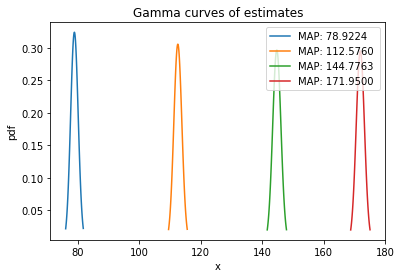

In [234]:
lambdaa=mean(list(june_de_data.tot_cases)+list(june_id_data.tot_cases))
beta=1/mean(list(june_de_data.tot_cases)+list(june_id_data.tot_cases))
likelihood_e=len(list(june_de_data.tot_cases)+list(june_id_data.tot_cases))
likelihood_l=sum(list(june_de_data.tot_cases)+list(june_id_data.tot_cases))
prior_e=beta
prior_l=0
post_vals=[]
for i in range(4):
    prior_l=likelihood_l+prior_l
    prior_e=likelihood_e+prior_e
    post_vals.append([prior_l+1,prior_e])
    next_week=list(rem_8weeks_de.tot_cases)[i*7:7+i*7]+list(rem_8weeks_id.tot_cases[i*7:7+i*7])
    likelihood_e=len(next_week)
    likelihood_l=sum(next_week)
    x = np.linspace(gamma.ppf(0.01, prior_l, scale=1/prior_e),gamma.ppf(0.99, prior_l,scale = 1/prior_e), 100)
    MAP = x[np.argmax(gamma.pdf(x, prior_l+1,scale=1/prior_e))]
    plt.plot(x, gamma.pdf(x, prior_l+1,scale=1/prior_e), label = 'MAP: %.4f ' %(MAP))
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend(loc="upper right")
plt.title('Gamma curves of estimates')
plt.show()
# print(post_vals)

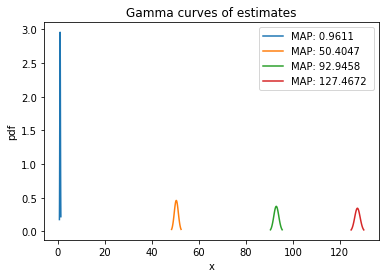

In [235]:
lambdaa=mean(list(june_de_data.tot_death)+list(june_id_data.tot_death))
beta=1/mean(list(june_de_data.tot_death)+list(june_id_data.tot_death))
likelihood_e=len(list(june_de_data.tot_death)+list(june_id_data.tot_death))
likelihood_l=sum(list(june_de_data.tot_death)+list(june_id_data.tot_death))
prior_e=beta
prior_l=0
post_vals=[]
for i in range(4):
    prior_l=likelihood_l+prior_l
    prior_e=likelihood_e+prior_e
    post_vals.append([prior_l+1,prior_e])
    next_week=list(rem_8weeks_de.tot_cases)[i*7:7+i*7]+list(rem_8weeks_id.tot_cases[i*7:7+i*7])
    likelihood_e=len(next_week)
    likelihood_l=sum(next_week)
    x = np.linspace(gamma.ppf(0.01, prior_l, scale=1/prior_e),gamma.ppf(0.99, prior_l,scale = 1/prior_e), 100)
    MAP = x[np.argmax(gamma.pdf(x, prior_l+1,scale=1/prior_e))]
    plt.plot(x, gamma.pdf(x, prior_l+1,scale=1/prior_e), label = 'MAP: %.4f ' %(MAP))
plt.xlabel('x')
plt.ylabel('pdf')
plt.legend(loc="upper right")
plt.title('Gamma curves of estimates')
plt.show()
# print(post_vals)

#Q2D

#Auto Regression

In [236]:
may_condition_de = (vaccine_daily_de['Date'] >= '2021-05-01') & (vaccine_daily_de['Date'] <= '2021-05-21')
may_condition_id = (vaccine_daily_id['Date'] >= '2021-05-01') & (vaccine_daily_id['Date'] <= '2021-05-21')
may_de_data_3week = list(vaccine_daily_de.loc[may_condition_de].Administered_new)
may_id_data_3week = list(vaccine_daily_id.loc[may_condition_id].Administered_new)


may_condition_de = (vaccine_daily_de['Date'] >= '2021-05-22') & (vaccine_daily_de['Date'] <= '2021-05-28')
may_condition_id = (vaccine_daily_id['Date'] >= '2021-05-22') & (vaccine_daily_id['Date'] <= '2021-05-28')
may_de_data_fweek = list(vaccine_daily_de.loc[may_condition_de].Administered_new)
may_id_data_fweek = list(vaccine_daily_id.loc[may_condition_id].Administered_new)

In [237]:
def Mape(pred_list,data_fweek):
    mape=0
    for i in range(len(data_fweek)):
        mape+=abs(data_fweek[i]-pred_list[i])*100/data_fweek[i]
        # print(mape)
    return mape/len(pred_list)

In [238]:
def SSE(pred_list,data_fweek):
    sse=0
    for i in range(len(data_fweek)):
        sse+=(data_fweek[i]-pred_list[i])**2
    return sse

In [239]:
def AR(X,data,n,data_fweek):
    Y = data[n:]
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(X), X)), np.transpose(X)), Y)
    X=np.array(data[21-n:])
    pred_list=[]
    for i in range(7):
        X_new=np.concatenate((np.array([1]),np.array(X)))
        # print(X_new)
        pred=np.matmul(X_new,np.transpose(beta))
        pred_list.append(pred)
        X=X[1:]
        X=np.append(X,np.array([pred]))
    mape=Mape(pred_list,data_fweek)
    sse=SSE(pred_list,data_fweek)
    print("Predicted values {}".format(pred_list))
    print("MAPE: {}".format(mape))
    print("SSE: {}".format(sse))




##Delaware

In [240]:
X = np.zeros((len(may_de_data_3week) - 3, 4))
for i in range(3, len(may_de_data_3week)):
  X[i-3][0] = 1
  X[i-3][1] = may_de_data_3week[i-1]
  X[i-3][2] = may_de_data_3week[i-2]
  X[i-3][3] = may_de_data_3week[i-3]
# print(X)
AR(X,may_de_data_3week,3,may_de_data_fweek)

Predicted values [5245.135173350598, 6074.488106027009, 5315.767157849295, 5668.735335358822, 5468.034418022151, 5602.7832622426195, 5531.740767125458]
MAPE: 39.301140146419925
SSE: 58853067.72178812


In [241]:
X = np.zeros((len(may_de_data_3week) - 5, 6))
for i in range(3, len(may_de_data_3week)):
  X[i-5][0] = 1
  X[i-5][1] = may_de_data_3week[i-1]
  X[i-5][2] = may_de_data_3week[i-2]
  X[i-5][3] = may_de_data_3week[i-3]
  X[i-5][4] = may_de_data_3week[i-4]
  X[i-5][5] = may_de_data_3week[i-5]
# print(X)
AR(X,may_de_data_3week,5,may_de_data_fweek)

Predicted values [6857.69661758383, 5785.737156960024, 4854.509485437036, 6543.923710474235, 6078.440685476724, 5390.12640980446, 5426.535117905697]
MAPE: 41.282178654379955
SSE: 55904938.92663492


##Idaho

In [242]:
X = np.zeros((len(may_id_data_3week) - 3, 4))
for i in range(3, len(may_id_data_3week)):
  X[i-3][0] = 1
  X[i-3][1] = may_id_data_3week[i-1]
  X[i-3][2] = may_id_data_3week[i-2]
  X[i-3][3] = may_id_data_3week[i-3]
# print(X)
AR(X,may_id_data_3week,3,may_id_data_fweek)

Predicted values [5731.793677557751, 5685.969911465983, 5469.399906431885, 5341.457518041079, 5466.614318139787, 5546.920649589637, 5509.07078980633]
MAPE: 69.39807336281974
SSE: 31662624.053393118


In [243]:
X = np.zeros((len(may_id_data_3week) - 5, 6))
for i in range(3, len(may_id_data_3week)):
  X[i-5][0] = 1
  X[i-5][1] = may_id_data_3week[i-1]
  X[i-5][2] = may_id_data_3week[i-2]
  X[i-5][3] = may_id_data_3week[i-3]
  X[i-5][4] = may_id_data_3week[i-4]
  X[i-5][5] = may_id_data_3week[i-5]
# print(X)
AR(X,may_id_data_3week,5,may_id_data_fweek)

Predicted values [7932.73158180788, 7243.634648882059, 5681.293730050635, 5365.94944179637, 4378.324687104982, 3954.838264066976, 4876.170986369067]
MAPE: 58.47159547995818
SSE: 25178959.06810081


#EWMA

In [244]:
def EWMA(data,alpha,data_fweek):
    data_c=copy.deepcopy(data)
    data_c+=data_fweek
    pred_list=[]
    y_t_hat=data_c[0]
    for j in range(28):
        # print(data_c)
        # ynew=0
        # for i in range(0,len(data_c)):
        #     ynew+=data_c[len(data_c)-(i+1)](1-alpha)*(i)
        # ynew*=alpha
        y_t=data_c[j]
        y_t_hat = alpha*y_t + (1-alpha)*y_t_hat
        pred_list.append(y_t_hat)
        # print(len(pred_list))
        # data_c.append(y_t_hat)
    mape=Mape(pred_list[21:],data_fweek)
    sse=SSE(pred_list[21:],data_fweek)
    # print(data_fweek)
    print("For alpha values: {}".format(alpha))
    print("Predicted values: {}".format(pred_list[21:]))
    print("MAPE: {}".format(mape))
    print("SSE: {}".format(sse))


##Delaware

In [245]:
EWMA(may_de_data_3week,0.8,may_de_data_fweek)
print()
EWMA(may_de_data_3week,0.5,may_de_data_fweek)

For alpha values: 0.8
Predicted values: [8849.40445625943, 8066.680891251885, 4790.9361782503765, 3829.387235650075, 3547.477447130015, 4787.895489426003, 9539.9790978852]
MAPE: 8.00423366131092
SSE: 2728957.4234906263

For alpha values: 0.5
Predicted values: [7284.087044715881, 7577.543522357941, 5774.77176117897, 4681.885880589485, 4079.4429402947426, 4588.721470147371, 7658.360735073686]
MAPE: 22.711774652755118
SSE: 19574796.35283082


##Idaho

In [246]:
EWMA(may_id_data_3week,0.8,may_id_data_fweek)
print()
EWMA(may_id_data_3week,0.5,may_id_data_fweek)

For alpha values: 0.8
Predicted values: [6931.14917297051, 6166.229834594102, 3577.24596691882, 1945.0491933837638, 3225.809838676753, 3805.1619677353506, 4166.63239354707]
MAPE: 10.463815894161465
SSE: 992641.5659346564

For alpha values: 0.5
Predicted values: [6110.145548820496, 6042.572774410248, 4486.286387205124, 3011.643193602562, 3278.821596801281, 3614.4107984006405, 3935.7053992003202]
MAPE: 27.345784680299452
SSE: 6604119.262423538
